In [2]:
import tensorflow as tf
import os
import keras
import numpy as np
import easygdf
import mne
import json
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, MaxPooling1D, Dropout, Flatten
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import get_data
from sklearn.model_selection import train_test_split
from colabcode import ColabCode
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

The network

In [ ]:
# Define the squeeze excitation block function
def squeeze_excitation_block(inputs, r):
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling1D()(inputs)
    se = layers.Dense(filters // r, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, filters))(se)
    out=inputs * se
    return out

# def SqueezeAndExcitation(inputs, ratio=8): 
#     b, _, _, c = inputs.shape 
#     x = GlobalAveragePooling2D()(inputs) 
#     x = Dense(c//ratio, activation="relu", use_bias=False)(x) 
#     x = Dense(c, activation="sigmoid", use_bias=False)(x) 
#     x = inputs * x 
#     return x 

# Set random seed for reproducibility
tf.random.set_seed(1234)

# Define input shape
input_shape = (1000,22)

# Define input layers for each branch
input_1 = tf.keras.Input(shape=input_shape)
input_2 = tf.keras.Input(shape=input_shape)
input_3 = tf.keras.Input(shape=input_shape)

# First Branch
x1 = tf.keras.layers.Conv1D(32, 20, strides=2, padding='same', kernel_regularizer=l2(0.01))(input_1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)
x1 = squeeze_excitation_block(x1, r=8)
x1 = tf.keras.layers.MaxPooling1D()(x1)



x1 = tf.keras.layers.Conv1D(32, 9, strides=2, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)
x1 = squeeze_excitation_block(x1, r=8)
x1 = tf.keras.layers.MaxPooling1D()(x1)
skip_connection1 = x1 ############

x1 = tf.keras.layers.Conv1D(32, 5, strides=1, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)

x1 = tf.keras.layers.Conv1D(32, 5, strides=1, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)
x1 = squeeze_excitation_block(x1, r=8)
x1 = tf.keras.layers.add([x1, skip_connection1])############
x1 = tf.keras.layers.MaxPooling1D()(x1)
skip_connection2 = x1 ############

x1 = tf.keras.layers.Conv1D(32, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)

x1 = tf.keras.layers.Conv1D(32, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.keras.layers.ELU()(x1)
x1 = squeeze_excitation_block(x1, r=8)
x1 = tf.keras.layers.add([x1, skip_connection2])############
x1 = tf.keras.layers.MaxPooling1D()(x1)
x1 = tf.keras.layers.Dropout(0.5)(x1)

x1 = tf.keras.layers.Flatten()(x1)

# Second Branch
x2 = tf.keras.layers.Conv1D(32, 13, strides=2, padding='same', kernel_regularizer=l2(0.01))(input_2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)
x2 = squeeze_excitation_block(x2, r=8)

x2 = tf.keras.layers.Conv1D(32, 7, strides=2, padding='same', kernel_regularizer=l2(0.01))(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)
x2 = squeeze_excitation_block(x2, r=8)
x2 = tf.keras.layers.MaxPooling1D()(x2)

x2 = tf.keras.layers.Conv1D(32, 5, strides=1, padding='same', kernel_regularizer=l2(0.01))(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)
x2 = squeeze_excitation_block(x2, r=8)
x2 = tf.keras.layers.MaxPooling1D()(x2)
skip_connection3 = x2

x2 = tf.keras.layers.Conv1D(32, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)

x2 = tf.keras.layers.Conv1D(32, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)
x2 = tf.keras.layers.ELU()(x2)
x2 = squeeze_excitation_block(x2, r=8)
x2 = tf.keras.layers.add([x2, skip_connection3])############
x2 = tf.keras.layers.MaxPooling1D()(x2)

x2 = tf.keras.layers.Dropout(0.5)(x2)

x2 = tf.keras.layers.Flatten()(x2)

# Third Branch
x3 = tf.keras.layers.Conv1D(32, 15, strides=2, padding='same', kernel_regularizer=l2(0.01))(input_3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.ELU()(x3)
x3 = squeeze_excitation_block(x3, r=8)
x3 = tf.keras.layers.MaxPooling1D()(x3)

x3 = tf.keras.layers.Conv1D(32, 10, strides=2, padding='same', kernel_regularizer=l2(0.01))(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.ELU()(x3)
x3 = squeeze_excitation_block(x3, r=8)

x3 = tf.keras.layers.Conv1D(32, 5, strides=1, padding='same', kernel_regularizer=l2(0.01))(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.ELU()(x3)
x3 = squeeze_excitation_block(x3, r=8)
x3 = tf.keras.layers.MaxPooling1D()(x3)

x3 = tf.keras.layers.Conv1D(48, 3, strides=1, padding='same', kernel_regularizer=l2(0.01))(x3)
x3 = tf.keras.layers.BatchNormalization()(x3)
x3 = tf.keras.layers.ELU()(x3)
x3 = squeeze_excitation_block(x3, r=8)
x3 = tf.keras.layers.MaxPooling1D()(x3)

x3 = tf.keras.layers.Dropout(0.5)(x3)

x3 = tf.keras.layers.Flatten()(x3)

# Concatenate the outputs of three branches
merged = tf.keras.layers.concatenate([x1, x2, x3])




#fc1 = tf.keras.layers.Dense(128, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(merged)
#fc2 = tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001))(fc1)

# Dropout layer
x = tf.keras.layers.Dropout(0.5)(merged)

# # Flatten layer
# x = layers.Flatten()(x)

# # Dense layer
# x = layers.Dense(64, activation='relu')(x)

# Output layer
output = tf.keras.layers.Dense(4, activation='softmax')(x)

# Create model
model = Model(inputs=[input_1, input_2, input_3], outputs=output)

# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Get events and their positions and also get eeg data 

In [ ]:
events_with_labels_arrays=get_data.event_position()

data_arrays=get_data.save_data_in_array()


In [13]:
def create_training_data(data_arrays,events_with_labels_arrays):
    labels = ["A01T","A02T", "A03T","A04T"]#,"A05T","A06T","A07T","A08T","A09T"

    train_data=[]

    for label in labels:

        temp_data=data_arrays[label]
        temp_events=events_with_labels_arrays[label]
        for i in range(len(temp_events)):
        
            if temp_events[i,1]==769 or temp_events[i,1]==770 or temp_events[i,1]==771 or temp_events[i,1]==772 :

                ev=temp_events[i,1]
                position=temp_events[i,0]
                # nth_sample=[]
                # for j in range(position, position+1000):
                #     if j==position+999:
                #         for k in range(1,23):
                #             nth_sample.append(temp_data[j,k])

                #         nth_sample.append(ev)    
                #         break
                #     for k in range(1,23):
                #         nth_sample.append(temp_data[j,k])
                sample=temp_data[position:position+1000,1:23]

                train_data.append((sample,ev))

    return train_data        

create train data

In [14]:

#add label for each row as last column
train_data=create_training_data(data_arrays,events_with_labels_arrays)


In [23]:
X, Y = zip(*train_data)
X=np.array(X)
Y=np.array(Y)

Y = Y.reshape(-1, 1)

create X and Y

In [76]:

#convert train_data to np array
# train_data = np.array(train_data)

# #Separate features (X) and labels (y)
# X = train_data[:, :-1]  # Extract all rows and all columns except the last one
# Y = train_data[:, -1]   # Extract all rows and only the last column

# #reshape Y to 2d array
# Y = Y.reshape(-1, 1)


Match each events to 0-3 class

In [25]:
for i in range(len(Y)):
    if Y[i]==769:
        Y[i]=0
    elif Y[i]==770:
        Y[i]=1
    elif Y[i]==771:
        Y[i]=2    
    elif Y[i]==772:
        Y[i]=3    
    

Shuffle X and Y train

In [78]:
# Generate shuffled indices
indices = np.arange(len(X))
np.random.shuffle(indices)

# Shuffle x_train and y_train using the shuffled indices
X_sh = X[indices]
Y_sh = Y[indices]



Split data to test and train

In [27]:
x_train, x_ , y_train, y_ =train_test_split(X, Y, test_size=0.20, random_state=1)

x_cv, x_test, y_cv, y_test =train_test_split(x_, y_, test_size=0.50, random_state=1)

# del x_ ,y_

Train the model

Epoch 1/250
47/47 [==============================] - 25s 119ms/step - loss: 6.9239 - accuracy: 0.2801 - val_loss: 5.9673 - val_accuracy: 0.3130
Epoch 2/250
47/47 [==============================] - 3s 72ms/step - loss: 6.5330 - accuracy: 0.3236 - val_loss: 5.7605 - val_accuracy: 0.4087
Epoch 3/250
47/47 [==============================] - 3s 73ms/step - loss: 6.1869 - accuracy: 0.3702 - val_loss: 5.6165 - val_accuracy: 0.4000
Epoch 4/250
47/47 [==============================] - 3s 74ms/step - loss: 5.9534 - accuracy: 0.3833 - val_loss: 5.4549 - val_accuracy: 0.4261
Epoch 5/250
47/47 [==============================] - 3s 72ms/step - loss: 5.7600 - accuracy: 0.3963 - val_loss: 5.3317 - val_accuracy: 0.4348
Epoch 6/250
47/47 [==============================] - 3s 72ms/step - loss: 5.5381 - accuracy: 0.4517 - val_loss: 5.1694 - val_accuracy: 0.4522
Epoch 7/250
47/47 [==============================] - 3s 73ms/step - loss: 5.3188 - accuracy: 0.4539 - val_loss: 5.0319 - val_accuracy: 0.4957
Epoc

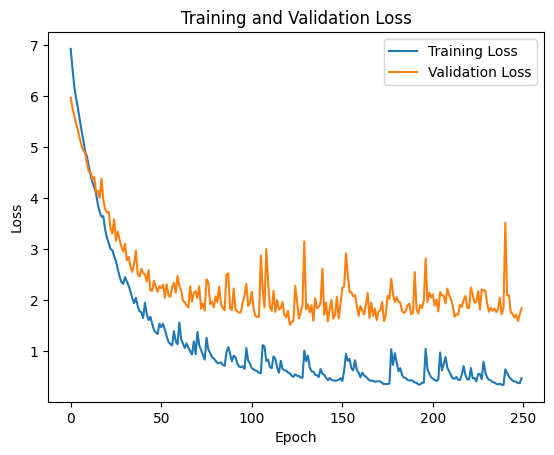

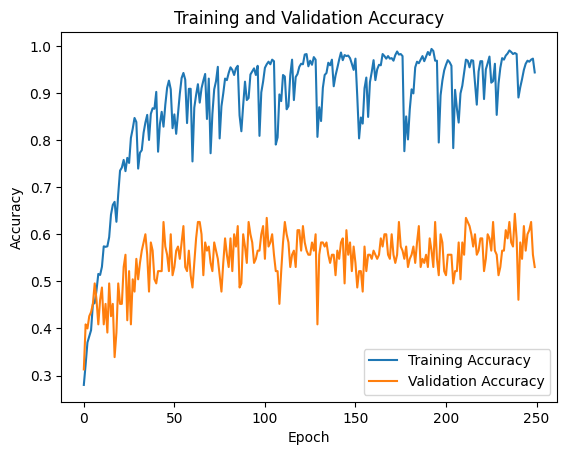

In [28]:
checkpoint = ModelCheckpoint("model_checkpoint.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model
history = model.fit(
    [x_train, x_train, x_train], y_train,
    epochs=250,
    batch_size=20,
    validation_data=([x_cv, x_cv, x_cv], y_cv)
    # callbacks=[checkpoint, early_stopping]
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [70]:
# Train the model
history=model.fit([x_train, x_train, x_train], y_train, epochs=100, batch_size=2, validation_split=0.2)

# Plot the training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show() 



Epoch 1/100
 59/184 [========>.....................] - ETA: 14s - loss: 4.2015 - accuracy: 0.7119

KeyboardInterrupt: 

In [62]:
# X_train_reshaped = x_train.reshape(-1, 22000)
# X_val_reshaped = x_cv.reshape(-1, 22000)
# X_test_reshaped = x_test.reshape(-1, 22000)

# # Initialize MinMaxScaler
# scaler = MinMaxScaler()

# # Fit scaler on training data and transform training, validation, and test data
# X_train_normalized = scaler.fit_transform(X_train_reshaped)
# X_val_normalized = scaler.transform(X_val_reshaped)
# X_test_normalized = scaler.transform(X_test_reshaped)

# # Reshape normalized data back to the original shape
# x_train_normalized = X_train_normalized.reshape(-1, 22000, 1)
# x_val_normalized = X_val_normalized.reshape(-1, 22000, 1)
# x_test_normalized = X_test_normalized.reshape(-1, 22000, 1)